In [1]:
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, MultiHeadAttention, Embedding, Add, Dropout, LayerNormalization
from tensorflow.keras.optimizers import Adam
import numpy as np
import bisect
import re
import math
import os

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
"""
# My tokenkization
from nltk.corpus import brown

for file in brown.fileids():
    clean_file = re.sub(r'/[^\s]+', ' ', brown.raw(file))
    dataset += clean_file + "\n" # Concatenate all the files together

dataset = re.sub(r'\s+', ' ', dataset)
len(dataset) # Number of characters
"""

'\n# My tokenkization\nfrom nltk.corpus import brown\n\nfor file in brown.fileids():\n    clean_file = re.sub(r\'/[^\\s]+\', \' \', brown.raw(file))\n    dataset += clean_file + "\n" # Concatenate all the files together\n\ndataset = re.sub(r\'\\s+\', \' \', dataset)\nlen(dataset) # Number of characters\n'

In [3]:
import pandas as pd
dataset = ""

texts = pd.read_csv('/kaggle/input/brown.csv')["tokenized_text"]
for text in texts:
    dataset += text
# Separate the punctuation from the words by a space
dataset = re.sub('[^a-zA-Z0-9\s]+', lambda x: x.group(0)[0] , dataset)    
dataset = re.sub(r'\s+', ' ', dataset)

dataset = dataset.split()

In [4]:
vocab = sorted(set(dataset))
vocab_size = len(vocab) + 2
vocab_size

61264

In [5]:
sentences = " ".join(dataset).split(".")
sentences = [s.split() for s in sentences if len(s.split())>0]
max_length = max([len(s) for s in sentences])
max_length

830

In [6]:
lengths = [len(s) for s in sentences]
print(np.mean(lengths), np.std(lengths), np.quantile(lengths, .999))

# 1 in 1000 sentences exceeds 128 so 128 it is.

19.899629529231046 15.372308871704446 118.66599999999744


In [7]:
sentence_length = 128 # 2 ** math.ceil(math.log2(max_length)) if we want to
# include every sentence. But truncating 1 in 1000 for 8x memory saving seems
# obvious.
pad_id = 0
start_id = 1

point = bisect.bisect_left(vocab, '.') + 2
dataset = np.zeros((len(sentences),  sentence_length + 1), dtype = np.float32) + pad_id

for i, sentence in enumerate(sentences):
    dataset[i, :min(len(sentence) + 2, sentence_length + 1)] = np.array([start_id] + [bisect.bisect_left(vocab, word) + 2 for word in sentence][:sentence_length - 1] + [point], dtype = np.float32)

vocab = ["<PAD>", "<S>"] + vocab

In [8]:
class FeedForward(tf.keras.Model):
    def __init__(self, emb_dim, units):
        super().__init__()
        self.dense1 = Dense(units, activation = "relu")
        self.dense2 = Dense(emb_dim)
        
    def call(self, x):
        x = self.dense1(x)
        out = self.dense2(x)
        return out

In [9]:
class Decoder(tf.keras.Model):
    def __init__(self, n_heads = 8, emb_dim = 512, units = 2048, dropout = .1):
        super().__init__()
        self.mha = MultiHeadAttention(n_heads, emb_dim//n_heads)
        self.dropout1 =  Dropout(dropout)
        self.ln1 = LayerNormalization()
        
        self.ffn = FeedForward(emb_dim, units)
        self.dropout2 =  Dropout(dropout)
        self.ln2 = LayerNormalization()
        
    def call(self, x, training):
        # Masked multi-head self-attention
        # The mask for the padding is problematic to implement here and it's more 
        # convenient to mask the loss function and we just use the look-ahead mask here.
        x1 = self.mha(x, x, x, use_causal_mask = True)
        x1 = self.dropout1(x1, training = training)
        x = self.ln1(x1 + x)
        
        x2 = self.ffn(x)
        x2 = self.dropout2(x2, training = training)
        x = self.ln2(x + x2)
        
        return x

In [10]:
class Transformer(tf.keras.Model):
    def __init__(self, vocab_size, sentence_length = 256, n = 6, n_heads = 8, emb_dim = 512, units = 2048, dropout = .1):
        super().__init__()
        # Embedding layer
        self.embedding = Embedding(vocab_size, emb_dim, input_length = sentence_length)
        # Positional encoding
        self.pos_encode = Add()
        self.decoder_stack = [Decoder(n_heads, emb_dim, units, dropout) for _ in range(n)]
        self.linear = Dense(vocab_size, activation = tf.nn.log_softmax)
        
    def call(self, x, training):
        
        x = self.embedding(x)
        x = self.pos_encode([x, pos_encoding])
        
        for decoder in self.decoder_stack:
            x = decoder(x, training)
        
        out = self.linear(x)
        
        return out

In [11]:
# For a generative model, label smoothing simply hurts perplexity which is what we care 
# about most. 
epsilon  = 0.0 # 0.1

def masked_loss(label, pred, pad_id = 0):
    mask = label != pad_id
    
    y = tf.one_hot(tf.cast(label, tf.int32), vocab_size, axis = -1)
    loss_object = tf.keras.losses.CategoricalCrossentropy(
    from_logits=True, reduction='none', label_smoothing = epsilon)
    loss = loss_object(y, pred)
    
    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
    return loss

In [12]:
class TransformerLearningRateSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, initial_learning_rate, warmup_steps, dtype=tf.float32):
        super(TransformerLearningRateSchedule, self).__init__()
        self.initial_learning_rate = initial_learning_rate
        self.dtype = dtype
        self.warmup_steps = tf.cast(warmup_steps, self.dtype)

    def __call__(self, step):
        step = tf.cast(step, self.dtype)
        warmup_steps = tf.cast(self.warmup_steps, self.dtype)
        x1 = tf.math.pow(step, tf.constant(-0.5, dtype = self.dtype))
        x2 = step * tf.math.pow(self.warmup_steps, tf.constant(-1.5, dtype = self.dtype))
        return self.initial_learning_rate * tf.math.minimum(x1, x2)

    def get_config(self):
        return {
            'initial_learning_rate': self.initial_learning_rate,
            'warmup_steps': self.warmup_steps,
            'dtype': self.dtype
        }

In [13]:
emb_dim = 256 # 512
n_heads = 4 # 8
units = 1024 # 2048
n = 3 # 6
dropout = 0.1 # 0.1
warmup_steps = 4000
#learning_rate = 1e-3
# Using a different learning rate than the paper as they train for many more steps.
learning_rate_schedule = TransformerLearningRateSchedule(emb_dim**-.5, warmup_steps)
optimizer = Adam(learning_rate_schedule, beta_1 = .9, beta_2 = .998, epsilon = 1e-9)

In [14]:
# Positional encoding
pos_encoding = np.zeros((sentence_length, emb_dim))
pos = np.arange(sentence_length)[:, np.newaxis]
even = np.arange(emb_dim, step = 2)[np.newaxis, :]
pos_encoding[:, ::2] = np.sin(pos/10**(4*even/emb_dim))
pos_encoding[:, 1::2] = np.cos(pos/10**(4*even/emb_dim))
pos_encoding = pos_encoding[np.newaxis, :, :] # Adding the batch dimension
pos_encoding = tf.cast(pos_encoding, dtype=tf.float32)

In [15]:
model = Transformer(vocab_size, sentence_length, n, n_heads, emb_dim, units, dropout)
model.compile(optimizer, masked_loss)
model.build((None, sentence_length))

model.summary()

Model: "transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       multiple                  15683584  
                                                                 
 add (Add)                   multiple                  0         
                                                                 
 decoder (Decoder)           multiple                  789760    
                                                                 
 decoder_1 (Decoder)         multiple                  789760    
                                                                 
 decoder_2 (Decoder)         multiple                  789760    
                                                                 
 dense_6 (Dense)             multiple                  15744848  
                                                                 
Total params: 33797712 (128.93 MB)
Trainable params: 33

In [16]:
batch_size = 32
epochs = 3

# X is simply the expected output shifted to the right with a <S> token at the beginning.
history = model.fit(dataset[:, :-1], dataset[:, 1:], batch_size, epochs, validation_split = .05)

Epoch 1/3
1643/1643 [==============================] - 306s 180ms/step - loss: 7.4721 - val_loss: 6.5390
Epoch 2/3
1643/1643 [==============================] - 282s 172ms/step - loss: 6.1878 - val_loss: 6.3113
Epoch 3/3
1643/1643 [==============================] - 283s 173ms/step - loss: 5.8355 - val_loss: 6.2247


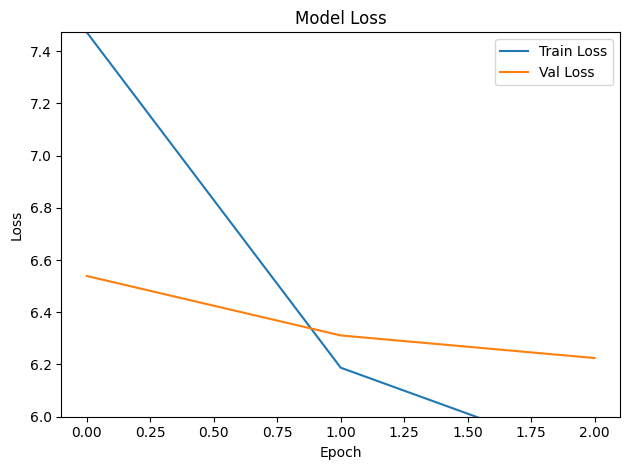

In [17]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.ylim(6, max(history.history['loss'] + history.history['val_loss']))
plt.tight_layout()
plt.show()

In [18]:
# Examining the 1st example.
x = dataset[0]
am = tf.nn.softmax(model(tf.reshape(x[:-1], (1, sentence_length))), axis = -1)
indices = map(int, x[1:])
am = tf.reshape(am, (-1, vocab_size))
probs = []
for i, idx in enumerate(indices):
    if idx == 0:
        break
    print(vocab[idx], float(am[i, idx]))
    probs.append(float(am[i, idx]))

Furthermore 0.00044496628106571734
, 0.6037073135375977
as 0.029604867100715637
an 0.011810892261564732
encouragement 4.5964497985551134e-05
to 0.04305797070264816
revisionist 3.76785101252608e-05
thinking 0.0009834084194153547
, 0.20905186235904694
it 0.08807332068681717
manifestly 3.40445403708145e-05
is 0.04192883521318436
fair 0.00028986961115151644
to 0.17485827207565308
admit 0.000260029686614871
that 0.21922433376312256
any 0.004574747756123543
fraternity 3.557905802153982e-05
has 0.005575184710323811
a 0.02964954264461994
constitutional 0.0001292814122280106
right 0.0005031063919886947
to 0.283304363489151
refuse 0.00020328252867329866
to 0.5054311156272888
accept 0.004417278803884983
persons 0.00015856004029046744
it 0.003256432246416807
dislikes 5.657256406266242e-05
. 0.2585285007953644


In [19]:
def softmax(logits, axis = -1):
    e = np.exp(logits)
    return e/np.sum(e, axis = axis)

def sample(n = 10, temperature = .7):
    for _ in range(n):
        x = np.zeros((sentence_length + 1)) 
        # The first token is <S> which is irrelevant to the output.
        x[0] = 1 # I could've used one-hot but making a sentence with one-hot seems weird. 
        i = 0
        choices = []
        choice = 0
        indices = list(range(vocab_size))
        
        while choice != point and i < sentence_length:
            out = np.ravel(model(x[:-1].reshape(1, sentence_length))[0, i])
            # output shape is (batch_size, sentence_length, vocab_size)
            probs = softmax(out / temperature, axis = -1)
            choice = np.random.choice(indices, p = probs)
            i = i+1
            x[i] = choice
            choices.append(choice)

        sample = " ".join(map(lambda x : vocab[x], choices))
        print(sample)

sample(25)

The final time of her horse had just been done .
This is a remarkable one of the important , a little man ' , he said .
He had been able to be a series of the old man and she was the hen .
The company of man , who began to hang to the first the English mission , a new New York .
The man had been doin' a little pastor .
I heard you don't have been required to go on the right .
, who had been sentenced to a decade and sounded , but there was the very feeling .
They were held by the small and their day , and the achievements of the movies , the postulate the beginning of the boys , larger than five days , and ran to the phone .
Be ten days , Julie .
Then I resent my mother , well spoken at all I ? ?It was the suitcase of the evening .
It wasn't that he would do that she had been open .
I know that I don't want .
12 .
It is a society of mind .
Without means that a century is high in the pseudophloem , there is a strong .
It was quickly a good time to her , but she had been able to be tryin

In [20]:
# model.save("GPT.keras")